## Kalman Filter

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

from moviepy.editor import *
from skimage.measure import find_contours
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.pyplot import Rectangle

In [2]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
DETECTIONS_DIR = Path(DATA_DIR, 'volleyball', 'detections')
FIGSIZE=(16,16)
LABEL_NAMES_COCO = ['person', 'sports ball']
LABEL_NAMES = ['red_team', 'blue_team', 'other', 'volleyball']
COLORS = {
    'red': (255,0,0),
    'green': (0,255,0),
    'blue': (0,0,255),
    'white': (255,255,255),
    'black': (0,0,0),
}
LABEL_COLORS = {
    'red_team': COLORS['red'],
    'blue_team': COLORS['blue'],
    'other': COLORS['green']
}

## Helpers

In [3]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr.astype('uint8'), cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def threshold_color(img, color, thresh, sigma=1.0):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = [b,g,r] margin allowed around color (1 per channel)
    """
    if isinstance(thresh, int):
        thresh = [thresh]*3
    thresh = np.array(thresh) * sigma
    min_color = np.array([color[0]-thresh[0], color[1]-thresh[1], 
                          color[2]-thresh[2]])
    max_color = np.array([color[0]+thresh[0], color[1]+thresh[1],
                          color[2]+thresh[2]])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def get_color_of_pixel(fpath, x, y, colorspace='BGR'):
    rgb_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
    hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
    
    rgb_colors = rgb_img[y,x,:]
    hsv_colors = hsv_img[y,x,:]
    bgr_colors = np.copy(rgb_colors[::-1])
    print ("BGR:", bgr_colors)
    print ("RGB:", rgb_colors)
    print ("HSV:", hsv_colors)
    
    # Plot to visualize
    img = np.copy(rgb_img)
    img[y-5:y+5:,x-5:x+5,:] = 255
    img[y,x,:] = 0
    
    if colorspace == 'BGR':
        return bgr_colors.tolist()
    if colorspace == 'RGB':
        return rgb_colors.tolist()
    return hsv_colors.tolist()

def get_hsv_value_of_bgr(bgr_color):
    print("BGR", bgr_color)
    bgr_color = np.uint8([[bgr_color]])
    hsv = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]
    print("HSV", hsv)
    return hsv

# Create color histograms representing average values among samples
def get_flattened_channels(imgs):
    chans = np.empty(shape=(1,3))
    for img in imgs:
        h,w,c = img.shape
        reshaped = img.reshape((h*w, c))
        chans = np.concatenate([chans, reshaped], axis=0)
        #print(reshaped.shape, chans.shape)
    return chans

def get_color_hist_dict(imgs, bins, ):
    chans = get_flattened_channels(imgs)
    bgr = ('b','g','r')
    hists = {
        'b':None,
        'g':None,
        'r':None
    }
    for i in range(len(chans[0])):
        hist, bins = np.histogram(chans[:,i], bins, [0,256])
        hists[bgr[i]] = hist
    return hists

def plot_hists_dict(hists):
    for col,hist in hists.items():
        plt.plot(hist, color=col)
    plt.show()
    
def get_color_hist(imgs, bins):
    chans = get_flattened_channels(imgs)
    hists = []
    for i in range(len(chans[0])):
        hist, bins = np.histogram(chans[:,i], bins, [0,256])
        hists.append(hist)
    return hists

def plot_hists(hists, title="None"):
    colors = ('r','g','b')
    for col,hist in zip(colors, hists):
        plt.plot(hist, color=col)
    plt.title(title)    
    plt.show()
    
def plot_bbs_from_rectLabel_annos(json_fpath, img_fpath):
    bb_json = json.load(open(json_fpath, 'r'))
    fig = plt.figure(figsize=FIGSIZE)
    axes = plt.axes([0, 0.03, 1, 0.97])
    
    img = plt.imread(img_fpath)
    imgplot = axes.imshow(img)

    for box in bb_json['objects']:
        label = box['label']
        color = BOX_COLORS[label]
        coords = box['x_y_w_h']
        bb = Rectangle(
            (coords[0],coords[1]), 
            coords[2], coords[3],
            fill=False,
            edgecolor=color,
            linewidth=2)
        axes.add_patch(bb)
        
def get_img_crops_from_rectLabel_bbs(img, json_fpath):
    crops_dict = {}
    bb_json = json.load(open(json_fpath, 'r'))
    for box in bb_json['objects']:
        label = box['label']
        x,y,w,h = box['x_y_w_h']
        crop = img[y:y+h,x:x+w,:]
        if label not in crops_dict:
            crops_dict[label] = []
        crops_dict[label].append(crop)
    return crops_dict

def make_boxes(meta):
    boxes = {}
    for idx,row in meta.iterrows():
        box = json.loads(row.to_json())
        fname = row['filename']
        if fname in boxes:
            boxes[fname].append(box)
        else:
            boxes[fname] = [box]
    return boxes

def median_filter(mask, ksize=3, thresh=25):
    median = cv2.medianBlur(mask, ksize)
    return median

def opening(img, ksize=(3,3)):
    # Erode --> Dilate
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    return img

def closing(img, ksize=(3,3)):
    # Dilate --> Erode
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    return img

def apply_bg_mask(fpaths, subtractor, limit=100, cleanup=None):
    i = 0
    masks = []
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        if cleanup == 'open':
            fgmask = opening(fgmask)
        elif cleanup == 'close':
            fgmask = closing(fgmask)
        elif cleanup == 'median':
            fgmask = median_filter(fgmask)
        fgmask[fgmask >= 2] = 255
        fgmask[fgmask < 2] = 0
        masks.append(fgmask)
        if i > limit:
            break
        i+=1
    return masks

def get_masked_imgs(fpaths, masks):
    imgs = []
    for fpath, mask in zip(fpaths, masks):
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        img[mask == 0] = 255
        imgs.append(img)
    return imgs

def get_img_crop(img, x1, y1, x2, y2):
    if len(img.shape) > 2:
        return img[y1:y2,x1:x2,:]
    return img[y1:y2,x1:x2]

def plot_boxes(img, rects, title="boxes", color=(255,255,255), thick=2):
    for (x1, y1, x2, y2) in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thick)
    plot_img(img, title=title)
    
    import random

def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def create_display_img(image, boxes, masks, labels, class_names, scores, ax=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1]

    if ax is None:
        _, ax = plt.subplots(1, figsize=FIGSIZE)

    # Generate random colors
    colors = random_colors(N)
    
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = (0.0, 1.0, 0.40000000000000036)# colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        score = scores[i] if scores is not None else None
        label = labels[i]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)

    return ax.imshow(masked_image.astype(np.uint8))

def get_label_hists(label, crops, plot=False, bins=20):
    avg_hist = get_color_hist(crops, bins=bins)
    comb_hist = cv2.calcHist(
        crops, [0, 1, 2], None, [bins, bins, bins], 
        [0, 256, 0, 256, 0, 256])
    avg_norm_hist = cv2.normalize(comb_hist, comb_hist).flatten()
    if plot:
        plot_hists(avg_hist,title=label)
        plt.plot(avg_norm_hist)
        plt.show()
    return avg_hist, avg_norm_hist

def draw_boxes(img, bbs, color=(0,255,0)):
    for (y1, x1, y2, x2) in bbs:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=2)
    return img

def get_center_court_line_y(x, slope, bias):
    return slope*x + bias

def filter_bbs(bbs, min_y, max_y, margin=0):
    valid_bbs = []
    for bb in bbs:
        valid = True
        y1, x1, y2, x2 = bb
        if y2 > max_y or y2 < min_y:
            valid = False
        w = x2 - x1
        h = y2 - y1
        area = w * h
        if area > 30000 or area < 2000:
            valid = False
        if valid:
            valid_bbs.append(bb)
    return valid_bbs

def classify_teams(bbs, court_details, margin=0):
    red_team = []
    blue_team = []
    referee = []
    for bb in bbs:
        y1, x1, y2, x2 = bb
        avg_x = (x1 + x2) / 2
        center_y = get_center_court_line_y(avg_x, court_details['center_line_slope'], 
                                           court_details['center_line_bias']) + margin
        if y2 <= center_y:
            blue_team.append(bb)
        else:
            red_team.append(bb)
    return red_team,blue_team

def filter_bbs(bbs, min_y, max_y, margin=0):
    valid_bbs = []
    for bb in bbs:
        valid = True
        y1, x1, y2, x2 = bb
        if y2 > max_y or y2 < min_y:
            valid = False
        w = x2 - x1
        h = y2 - y1
        area = w * h
        if area > 30000 or area < 2000:
            valid = False
        if valid:
            valid_bbs.append(bb)
    return valid_bbs

def is_valid_bb(bb, min_y, max_y, margin=0):
    y1, x1, y2, x2 = bb
    if y2 > max_y or y2 < min_y:
        return False
    w = x2 - x1
    h = y2 - y1
    area = w * h
    if area > 30000 or area < 2000:
        return False
    return True

def classify_detection(bb, court_details, margin=0):
    slope = court_details['center_line_slope']
    bias = court_details['center_line_bias']
    min_y = court_details['outer_court_top_y']
    max_y = court_details['outer_court_bottom_y']
    if not is_valid_bb(bb, min_y, max_y, margin):
        return 'other'
    y1, x1, y2, x2 = bb
    avg_x = (x1 + x2) / 2
    center_y = get_center_court_line_y(avg_x, slope, bias) + margin
    if y2 <= center_y:
        return 'blue_team'
    return 'red_team'

def process_detections(img_fpaths, court_details, save=False):
    y_feet_offset = 0
    detections = {}
    for img_fpath in img_fpaths:
        det_fpath = Path(DETECTIONS_DIR, Path(img_fpath).name + '.npy')
        img_detections = np.load(det_fpath)[0]
        img_detections['labels'] = []
        img_detections['positions'] = []
        for idx,bb in enumerate(img_detections['rois']):
            y1, x1, y2, x2 = bb
            label = classify_detection(bb, court_details, margin=5)
            img_detections['labels'].append(label)
            img_detections['positions'].append({
                'bb': [x1,y1,x2,y2],
                'label': label,
                'color': LABEL_COLORS[label],
                'x_feet': (x2+x1)//2,
                'y_feet': y2 + y_feet_offset,
                'x_body': (x2+x1)//2,
                'y_body': (y2+y1)//2,
            })
        detections[img_fpath] = img_detections
        if save:
            img_det_fpath = Path(
                DETECTIONS_DIR, Path(img_fpath).name + '.processed.npy')
            np.save(img_det_fpath, img_detections)
    return detections

def load_raw_detections(img_fpaths):
    dets = {}
    for fpath in img_fpaths:
        det_fpath = Path(DETECTIONS_DIR, Path(fpath).name + '.npy')
        dets[fpath] = np.load(det_fpath)[0]
    return dets

def load_processed_detections(img_fpaths):
    dets = {}
    for fpath in img_fpaths:
        det_fpath = Path(DETECTIONS_DIR, Path(fpath).name + '.processed.npy')
        dict_ = np.load(det_fpath).reshape((1,))[0]
        dets[fpath] = dict_
    return dets

def get_player_bbs(img_det):
    bbs = filter_bbs(img_det['rois'], TOP_COURT_Y, BOTTOM_COURT_Y, margin=3)
    red,blue = classify_teams(bbs, CENTER_COURT_LINE_Y, margin=10)
    return red,blue

def draw_detections(img, detections, plot_all=False):
    bbs = detections['rois']
    labels = detections['labels']
    positions = detections['positions']
    for idx in range(len(bbs)):
        y1, x1, y2, x2 = bbs[idx]
        color = positions[idx]['color']
        if labels[idx] in ['red_team', 'blue_team'] or plot_all:
            cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=2)
    return img

def get_genius_box(fname, gt_boxes):
    """
    {'filename': 'volleyball_frame_00665.png',
       'fpath': '../data/volleyball/images_subset/volleyball_frame_00665.png',
       'label_id': 1,
       'label_name': 'ball',
       'x1': 45.5,
       'x2': 64.5,
       'y1': 175.0,
       'y2': 195.0}
       """
    bb = gt_boxes[fname][0]
    coords = [bb['x1'],bb['y1'],bb['x2'],bb['y2']]
    coords = [int(c) for c in coords]
    return np.array(coords)

def plot_gt_boxes(img, rects, title="boxes", color=(255,255,255), 
                  thick=2, texts=None, gt_box=None):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.rectangle(img, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255,0,0), 1 )
    for (x1, y1, x2, y2), text in zip(rects, texts):
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 1 )
        cv2.putText(img, text, (x1,y1), font, 1, (255,255, 255), 1, cv2.LINE_AA)
    plot_img(img, title=title)

In [4]:
metadata = pd.read_csv(metadata_fpath)
fnames = metadata['filename']
fpaths = [os.path.join(IMG_DIR, f) for f in fnames]
metadata['fpath'] = fpaths
GT_BOXES = make_boxes(metadata)

## Load GT Boxes

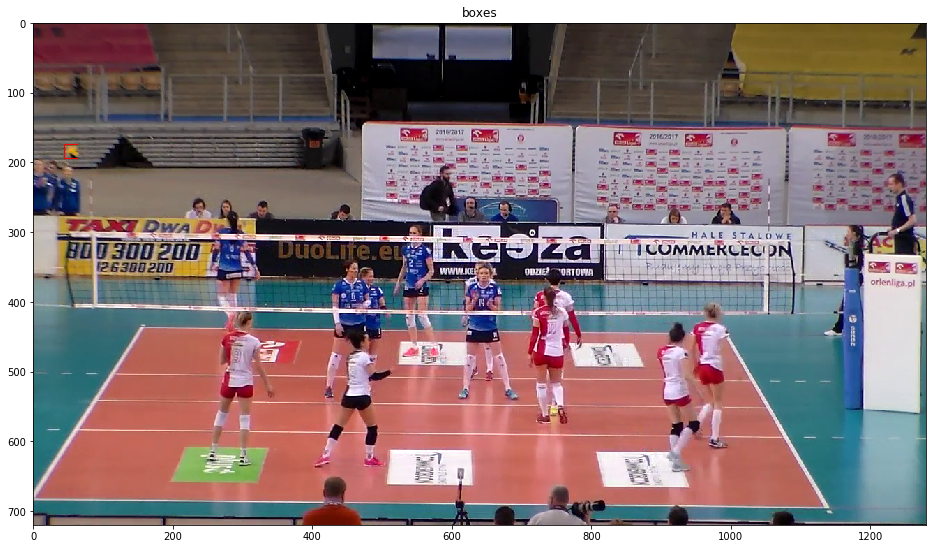

In [5]:
# Let's start with single object tracking of the ball, since we have the annotations
fname = metadata['filename'][0]
fpath = metadata['fpath'][0]
gt_box = get_genius_box(fname, GT_BOXES)
img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
plot_gt_boxes(img, rects=[], title="boxes", color=(255,255,255), 
                  thick=2, texts=[], gt_box=gt_box)

## OpenCV Kalman Filter

In [6]:
"""
System of Linear Equations

Input = collection of two or more linear equations involving the same set of variables (x,y,z)
Output = values for the variables (x,y,z) such that all equations are simultaneously satisfied

Ways to solve:
https://en.wikipedia.org/wiki/System_of_linear_equations#Vector_equation
1) Elimination of variables
2) Row reduction
3) Cramer's rule

Larger # of variables
4) Gaussian elimination
5) SVD
6) Least squares

In-homogenous
2x + 3y = 4
Homogenous
2x + 3y -4 = 0

Why convert to Homogenous?
* Can represent affine transforms
* Can be more easily multiplied/combined
* Can be solved with SVD

We can represent systems of linear equations with matrices
2x + 3y + 2 = 0
5x + 8y + 1 = 0

[2 3 2] * [x]
[5 8 1]   [y]
          [1]
          
We can also represent a single equation as a diagonal matrix
This is called a "linear transformation". It stores the coefficients (the transforms)
of the linear equation.

2x + 3y + 2 = 0

[2 0 0] * [x]
[0 3 0]   [y]
[0 0 2]   [1]

Why do we do this?
1) For graphics we use this form to represent transforms in a concise way
   In the example above we can do affine transformation (translate, scale, rotate)
2) For linear equations, it's shorthand for applying a linear transformation (Kalman Filter)

So in our Kalman example, we have a linear dynamics model (kinetic)

current_position = prior_position + (time_delta * velocity)
Xt = Xt-1 + dt*vt

And we add some gaussian noise (randomly sampled from our covariance matrix):

current_position = prior_position + (time_delta * velocity) + noise
Xt = Xt-1 + dt*vt + wt

* Xt = current location (x,y) at time t
* Dt = time delta
* Vt = velocity at time t
* Wt = noise

This linear dynamics model can be represented as a linear transformation (to simplify multiplication and computation). We will 'apply' this transform to our inputs.
Given this is a `linear` dynamics model. We assume constant velocity, so our coefficients for x and y are 1 (constant). There is no scale, only translation, which equals the time delta * 

So for example, simplifing the dynamics model into X and Y
Xt = Xt-1 + dT*vT

We make it homogenous so we can include translation (linear transformation) in the same matrix and do `efficient` matrix multiplication.

[1  0  dt  0] * [Xt-1]
[0  1  0  dt]   [Yt-1]
[0  0  1   0]   [ Vx ]
[0  0  0   1]   [ Vy ]

# State
Ft = state dynamics model
Xt = state estimate (data)
Pt = state covariance matrix (error_covariance_matrix)
Qt = process_noise_matrix (covariance)
Wt = process noise vector (data)

# Measuremenet
Yt = measurement estimate
St = measurement covariance matrix
Rt = measurement_noise_matrix (covariance)
Vt = measurement noise vector (data)

# Other
Bt = control model
Ut = control vector (data)
Wt = process
Kt = Kalman gain

### Steps ###
1. Predict

Xt = Ft*Xt-1 + Bt*Ut + wt
Pt = Ft*Pt-1*Ft.T + Qt

2. Measure

Zt = Ht*Xt + Vt
Yt = Zt - Ht*Xt
St = Rt + Ht*Pt*Ht.T

3. Update

Compute Kalman gain and update state estimate and process covariance

### DYNAMICS MODEL ###
Ft = transition_matrix = dynamics model
Xt = state estimate matrix
Pt = state covariance matrix
Qt = process noise covariance matrix

Ft Without Noise:

[Xt] = [1 0 dt 0 ] * [Xt-1] 
[Yt] = [0 1 0  dt]   [Yt-1]
       [0 0 1  0 ]   [ Vx ]
       [0 0 0  1 ]   [ Vy ]

Ft With Noise:

[Xt] = [1 0 dt 0  Nx 0] * [Xt-1] 
[Yt]   [0 1 0  dt 0 Ny]   [Yt-1]
[Vx]   [0 0 1  0  0  0]   [ Vx ]
[Vy]   [0 0 0  1  0  0]   [ Vy ]
                          [  1 ]
                          [  1 ]

Qt Noise Covariance Matrix
[ Ex   0   0     0     ]
[ 0    Ey  0     0     ]
[ 0    0   Ev_x  0     ]
[ 0    0   0     Ev_y  ]

### MEASUREMENT MODEL ###
Ht = measurement_matrix = observation model
Yt = measurement estimate (data)
St = measurement covariance matrix
Rt = measurement_noise_matrix (covariance)

Ht Without Noise
[Xt] = [1 0] * [Xt-1]
[Yt]   [0 1]   [Yt-1]        

Ht With Noise
[Xt] = [1 0 Nx 0] * [Xt-1]
[Yt]   [0 1 0 Ny]   [Yt-1]        
                    [  1 ]
                    [  1 ]

### OpenCV ###

dynamParams – Dimensionality of the state.
measureParams – Dimensionality of the measurement.
controlParams – Dimensionality of the control vector.
type – Type of the created matrices that should be CV_32F or CV_64F.
dynamParams [x1,y1,x2,y2,ux,uy]

process_noise_matrix = noise model
measurement_noise_matrix = measurement noise model
error_covariance_matrix = process covariance matrix

np.eye(N,M, k) Returns diagonal matrix of ones
N=row,M=col,k= index of diagonal start (offset)
""";
n_states = 6 # [x, y, vx, vy]
n_measurements = 2 # [x, y]
n_controls = 0 # action controls (external, known change to the system each timestep)
FPS = 20

# dt = time delta between measurements
dt = 1 / FPS
kf = cv2.KalmanFilter(n_states, n_measurements, n_controls)

In [134]:
def draw_pred_meas(img, i, trail, predictions, measurements):
    start = max(0, i-trail)
    for pred,meas in zip(predictions[start:i+1], measurements[start:i+1]):
        pred_pt = pred[0],pred[1]
        meas_pt = meas[0],meas[1]
        if meas[0] > 0 and meas[1] > 0:
            cv2.circle(img, meas_pt, 1, color=(0,255,0), thickness=8)
        cv2.circle(img, pred_pt, 1, color=(255,0,0), thickness=8)
    return img

def getVelocityKalman(dt=1, process_noise=.03, meas_noise=.00003):
    ### Dynamics ###
    n_states = 4 # [x, y, vx, vy]
    n_measurements = 2 # [x, y]
    n_controls = 0 # action controls (external, known change to the system each timestep)
    FPS = 20

    # dt = time delta between measurements
    dt = 1 / FPS
    kf = cv2.KalmanFilter(n_states, n_measurements, n_controls)

    # Ft - Model
    kf.transitionMatrix = np.array([
        [1, 0, dt, 0], 
        [0, 1, 0, dt], 
        [0, 0, 1,  0], 
        [0, 0, 0,  1]
    ], np.float32)

    # Xt - Prediction
    # kf.statePre
    # kf.statePost

    # Pt - Model Covariance 
    # Pt = state covariance matrix (error_covariance_matrix)
    # kf.errorCovPre
    # kf.errorCovPost

    # Qt - Noise Covariance
    kf.processNoiseCov = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], np.float32) * process_noise


    ### Measurements ###

    # Ht - Measurement Model
    kf.measurementMatrix = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ], np.float32)

    # Yt - Sensor Measurement Vector
    # You input this custom - column-wise observation

    # Rt - Measurement Noise 
    kf.measurementNoiseCov = np.array([
        [1, 0], 
        [0, 1]
    ], np.float32) * meas_noise

    # K = Kalman Gain
    # kf.gain
    return kf

def getKalmanWAcceleration(dt=1, process_noise=.03, meas_noise=.00003):
    # Includes Acceleration ?
    ### Dynamics ###
    n_states = 6 # [x, y, vx, vy, ax, ay]
    n_measurements = 2 # [x, y]
    n_controls = 0 # action controls (external, known change to the system each timestep)
    FPS = 20

    # dt = time delta between measurements
    dt = 1 / FPS
    kf = cv2.KalmanFilter(n_states, n_measurements, n_controls)

    # Ft - Model
    kf.transitionMatrix = np.array([
        [1, 0, dt, 0, .5*dt**2,  0], 
        [0, 1, 0, dt,  0,  5*dt**2], 
        [0, 0, 1, 0,   0,   0], 
        [0, 0, 0, 1,   0,   0],
        [0, 0, 0, 0,   1,   0], 
        [0, 0, 0, 0,   0,   1]
    ], np.float32)

    # Xt - Prediction
    # kf.statePre
    # kf.statePost

    # Pt - Model Covariance 
    # Pt = state covariance matrix (error_covariance_matrix)
    # kf.errorCovPre
    # kf.errorCovPost

    # Qt - Process Noise Covariance (http://campar.in.tum.de/Chair/KalmanFilter)
        # Higher Q, more noise, less weight to state prediction, more weight to measurements
        # Lower Q, less noise, more weight to state prediction
        # If Q == zero the KFwill pretty much ignore the data.

    kf.processNoiseCov = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ], np.float32) * process_noise


    ### Measurements ###

    # Ht - Measurement Model
    kf.measurementMatrix = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ], np.float32)

    # Yt - Sensor Measurement Vector
    # You input this custom - column-wise observation

    # Rt - Measurement Noise Covariance (http://campar.in.tum.de/Chair/KalmanFilter)
        # Determines how much information from the measurement is used.
        # Higher R, more noise, less weight to measurements
        # Lower R, less noise, more weight to measurements

    kf.measurementNoiseCov = np.array([
        [1, 0], 
        [0, 1]
    ], np.float32) * meas_noise

    # K = Kalman Gain
    # kf.gain
    return kf


def run_kalman(kf, frames, observations, n_trail=5, verbose=False):
    measurements = []
    predictions = []
    annotated_frames = []
    trail = 5
    for i in range(len(frames)):
        frame,meas = frames[i], observations[i]
        pred = kf.predict()
        if verbose:
            print("Prediction Vector", pred.shape, pred)
            print("Measurement Vector", meas.shape, meas)
        if meas[0] > 0 and meas[1] > 0:
            kf.correct(meas)
        meas = np.array([int(m) for m in meas])
        pred = np.array([int(p) for p in pred])
        img = draw_pred_meas(frame, i, trail, predictions, measurements)
        annotated_frames.append(img)
        measurements.append(meas)
        predictions.append(pred)
    return predictions, measurements, annotated_frames

In [154]:
# Format Observations
start, stop = 30,80
meas_idxs = [0,1] #x,y
frames = []
observations = []
for i in range(start,stop):
    fname = metadata['filename'][i]
    fpath = metadata['fpath'][i]
    gt_box = get_genius_box(fname, GT_BOXES)
    obs = np.array([gt_box[idx] for idx in meas_idxs]).astype(np.float32)
    img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
    frames.append(img)
    observations.append(obs)

In [155]:
# Thin out with slices
kalman_obs = []
slice_size = 10  #the gap between observations
for i in range(0,stop-start):
    if i % slice_size == 0:
        kalman_obs.append(observations[i].copy())
    else:
        kalman_obs.append(np.array([0., 0.]).astype("float32"))
kalman_obs = np.array(kalman_obs)
observations = np.array(observations)

In [156]:
def get_preds_meas_imgs(kf, frames, obs):
    predictions,measurements,imgs = run_kalman(kf, frames, obs, n_trail=5, verbose=False)
    predictions = np.array(predictions)
    h,w,c = imgs[0].shape
    predictions[:,1] = h - predictions[:,1]
    return predictions,obs,measurements,imgs

In [157]:
# Kalman w Velocity
process_noise = [1.,0.,.5,.05,.005]
meas_noise = [1.,.5, .005,.00005,.000005, 0.]
velocity_preds = []
for i in range(len(meas_noise)):
    kf = getVelocityKalman(dt=slice_size, process_noise=process_noise[3], meas_noise=meas_noise[i])
    preds,obs,meas,imgs = get_preds_meas_imgs(kf, frames, kalman_obs)
    velocity_preds.append(preds)

In [158]:
# Plot X,Y
# Need to flip y axis for plotting (img coords for Y are flipped)
h,w,c = imgs[0].shape
observations[:,1] = h - observations[:,1]
kalman_obs[:,1] = h - kalman_obs[:,1]

(0, 720)

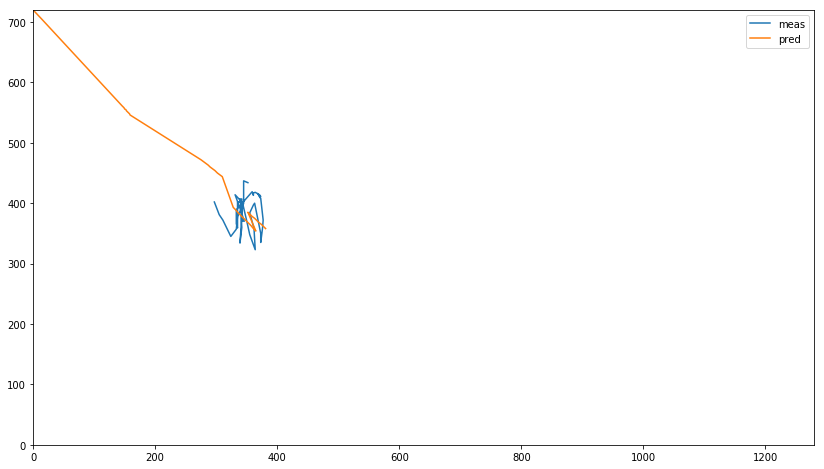

In [159]:
fig = plt.figure(figsize=(14,8))
plt.plot(observations[:,0], observations[:,1], label='meas')
plt.plot(velocity_preds[0][:,0], velocity_preds[0][:,1], label='pred')
plt.legend()
plt.xlim(0,1280)
plt.ylim(0,720)

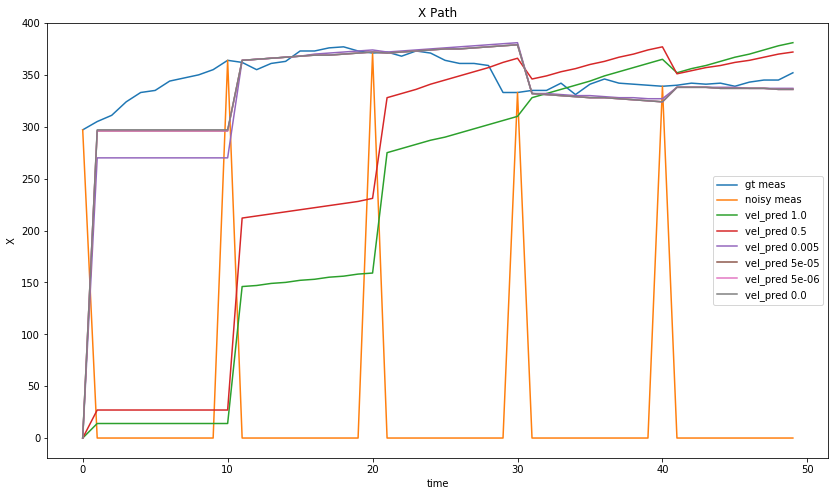

In [160]:
# X Path
fig = plt.figure(figsize=(14,8))
plt.plot(observations[:,0], label='gt meas')
plt.plot(kalman_obs[:,0], label='noisy meas')
for idx,preds in enumerate(velocity_preds):
    plt.plot(preds[:,0], label='vel_pred ' + str(meas_noise[idx]))
plt.xlabel('time')
plt.legend()
plt.ylabel('X')
plt.title("X Path");

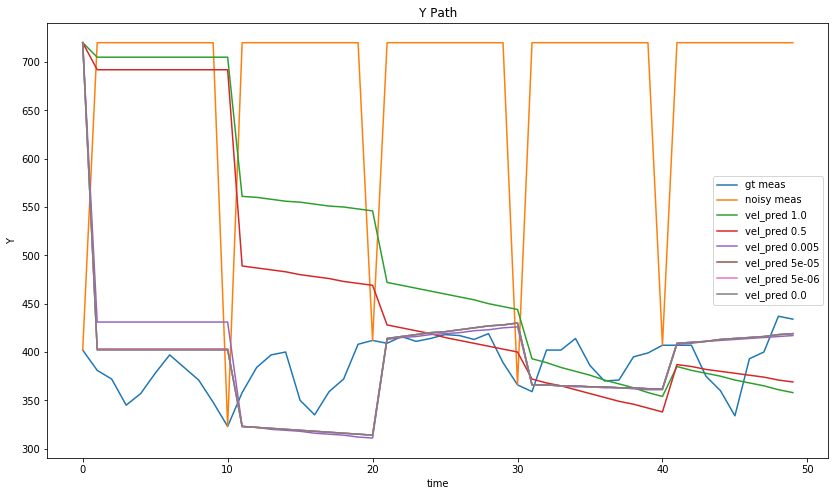

In [161]:
# Y Path
fig = plt.figure(figsize=(14,8))
plt.plot(observations[:,1], label='gt meas')
plt.plot(kalman_obs[:,1], label='noisy meas')
for idx,preds in enumerate(velocity_preds):
    plt.plot(preds[:,1], label='vel_pred ' + str(meas_noise[idx]))
plt.xlabel('time')
plt.legend()
plt.ylabel('Y')
plt.title("Y Path");

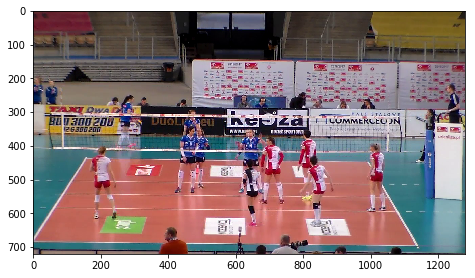

In [151]:
fig = plt.figure()
axes = plt.axes([0, 0.03, 1, 0.97])
img = imgs[0]
imgplot = axes.imshow(img, animated=True)
def init():
    return (imgplot,)

def animate(img):
    imgplot.set_array(img)
    return (imgplot,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=imgs, interval=200, blit=True)

In [152]:
# ~1 minute to generate
HTML(anim.to_html5_video())

## Tracking w Kalman Filter

In [ ]:
"""
Track

id : the integer ID of the track
bbox : the current bounding box of the object; used for display
kalmanFilter : a Kalman filter object used for motion-based tracking
age : the number of frames since the track was first detected
totalVisibleCount : the total number of frames in which the track was detected (visible)
consecutiveInvisibleCount : the number of consecutive frames for which the track was not detected (invisible).
"""


In [ ]:
import uuid
def make_id():
    return uuid.uuid1().hex[:10]

track_template = {
    "id": None,
    "detected_bbs": [],
    "tracked_bbs": [],
    "status": [],
    "kalman": None,
    "age": 0,
    "total_frames_visible": 1,
    "frames_since_last_visible": 0,
}

In [ ]:
class KalmanFilter():
    def __init__(self, initial_bb, motion_model, noise_model):
        self.initial_bb = initial_bb
        self.motion_model = motion_model
        self.noise_model = noise_model

    def predict(self):
        return None
    
    def correct(self, detection):
        return None

def init_kalman_filter(detection):
    kf = cv2.KalmanFilter(6, 4)
    return kf

def track_object(bbox=None, track=None):
    if track is None and bbox is None:
        return None
    elif track is None and bbox is not None:
        track = track_template.copy()
        track['id'] = make_id()
        track['detected_bbs'].append(bbox)
        track['kalman'] = init_kalman_filter(bbox)
        corrected_bb = track['kalman'].correct(bbox)
        track['tracked_bbs'].append(corrected_bb)
        track['status'].append('Initial')
    elif bbox is not None:
        track['detected_bbs'].append(bbox)
        corrected_bb = track['kalman'].correct(bbox)
        track['tracked_bbs'].append(corrected_bb)
        track['status'].append('Corrected')
    else:
        predicted_bb = track['kalman'].predict(bbox)
        track['tracked_bbs'].append(predicted_bb)
        track['status'].append('Predicted')
    return track

track_object(bbox=np.array([gt_box]))

## Save Video

In [ ]:
clip = ImageSequenceClip(floor_map_frames, fps=40)
outdir = Path(DATA_DIR, 'volleyball', 'ball_tracking')
outdir.mkdir(exist_ok=True)
outfpath = str(Path(outdir, 'ball_tracking_kalman_filter.mp4'))
clip.write_videofile(outfpath)

## Links

![HEY](https://github.com/srianant/kalman_filter_multi_object_tracking/blob/master/images/KF_arch.png?raw=true)

Papers:
* http://vc.cs.nthu.edu.tw/home/paper/codfiles/wyyang/201505280559/06935235.pdf
* https://arxiv.org/pdf/1608.06148.pdf
* https://pdfs.semanticscholar.org/9336/9053da157dacff28d6205c7c6f7fa4b9ddf0.pdf
* https://pdfs.semanticscholar.org/616b/7093cfe6ec679f25d63f62c16e937227258f.pdf
* http://faculty.ucmerced.edu/mhyang/papers/cviu17_MOT.pdf
* https://www.ethz.ch/content/dam/ethz/special-interest/baug/igp/photogrammetry-remote-sensing-dam/documents/pdf/cvpr2012-anton.pdf

Tutorials:
* https://home.wlu.edu/~levys/kalman_tutorial/
* https://www.mathworks.com/help/vision/examples/using-kalman-filter-for-object-tracking.html
* https://www.mathworks.com//help/vision/examples/motion-based-multiple-object-tracking.html
* http://studentdavestutorials.weebly.com/multi-bugobject-tracking.html
* https://www.myzhar.com/blog/tutorials/tutorial-opencv-ball-tracker-using-kalman-filter/

Assigning Tracks
* https://stackoverflow.com/questions/26363257/tracking-multiple-moving-objects-with-kalmanfilter-in-opencv-c-how-to-assign (BB IoU)
* http://www.hungarianalgorithm.com/examplehungarianalgorithm.php
* https://www.topcoder.com/community/data-science/data-science-tutorials/assignment-problem-and-hungarian-algorithm/
* https://www.youtube.com/watch?v=cQ5MsiGaDY8 (Good Hungarian intro)

Theory
* https://en.wikipedia.org/wiki/Kalman_filter
* http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
* https://www.youtube.com/watch?v=aUkBa1zMKv4 (particle)
* http://bilgin.esme.org/BitsAndBytes/KalmanFilterforDummies
* http://campar.in.tum.de/Chair/KalmanFilter

Repos
* https://github.com/nwojke/deep_sort
* https://github.com/srianant/kalman_filter_multi_object_tracking
* https://github.com/Smorodov/Multitarget-tracker
* https://github.com/Myzhar/simple-opencv-kalman-tracker
* https://github.com/abewley/sort
* https://github.com/ZidanMusk/experimenting-with-sort
* https://github.com/cmoscardi/bus_kalman